In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [18]:
class CarData:
    
    missing = -1
    duplicates = -1
    
    price_outliers = -1
    mileage_outliers = -1
    year_outliers = -1
    total_discard = -1
    
    def __init__(self, path, price_outlier_mt = 200000, mileage_outlier_mt = 400000,
                 year_outlier_lt = 1995, engine_outlier_mt = 4000, engine_outlier_lt = 750):
        
        #define parameters
        self.price_outlier_mt = price_outlier_mt
        self.mileage_outlier_mt = mileage_outlier_mt
        self.year_outlier_lt =  year_outlier_lt
        self.engine_outlier_mt = engine_outlier_mt
        self.engine_outlier_lt = engine_outlier_lt
        
        #read all .csv files from the directory
        self.data = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))), sort=False)
        
        #drop the duplicates and save the number of duplicates - many duplicates due to data gathering method
        self.duplicates = len(self.data) - len(self.data.drop_duplicates())
        self.data.drop_duplicates(inplace = True)
        
        #rename columns
        self.data.columns = ['title', 'price', 'sub_title', 'mileage_km', 'year', 'engine_cm3',
                'engine_type', 'city', 'province', 'negotiable']
        
        #drop NaNs and save the number of rows dropped to the missing varaible
        self.missing = self.data['engine_type'].isna().sum()
        self.data.dropna(subset = ['engine_type'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['city'].isna().sum()
        self.data.dropna(subset = ['city'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['engine_cm3'].isna().sum()
        self.data.dropna(subset = ['engine_cm3'], axis = 'index', inplace = True)
        
        #clean up the columns
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(",", ""))
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(" ", "")).astype('int')
        
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace("km", ""))
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace(" ", "")).astype('int')
        
        self.data['engine_cm3'] = self.data['engine_cm3'].astype('str')
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace('cm3', ''))
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace(' ','')).astype('int')
        
        self.data['province'] = self.data['province'].astype('str')
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('(',''))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace(')',''))
    
        #Add ID column
        self.data.insert(loc = 0, column = 'ID', value = range(1, len(self.data)+1))

        #discard outliers and calculate the numbers
        self.total_discard = len(self.data) - len(self.data[(self.data['price'] <= self.price_outlier_mt) &
                                                        (self.data['mileage_km'] <= self.mileage_outlier_mt) &
                                                        (self.data['year'] >= self.year_outlier_lt) &
                                                        (self.data['engine_cm3'] <= self.engine_outlier_mt) &
                                                           (self.data['engine_cm3'] >= self.engine_outlier_lt)])        
        
        self.price_outliers = len(self.data[self.data['price'] > price_outlier_mt])
        self.data = self.data[self.data['price'] <= price_outlier_mt]
        
        self.mileage_outliers = len(self.data[self.data['mileage_km'] > mileage_outlier_mt])
        self.data = self.data[self.data['mileage_km'] <= mileage_outlier_mt]
        
        self.year_outliers = len(self.data[self.data['year'] < year_outlier_lt])
        self.data = self.data[self.data['year'] >= year_outlier_lt]
        
        self.engine_outliers = len(self.data[(self.data['engine_cm3'] > engine_outlier_mt) |
                                            (self.data['engine_cm3'] < engine_outlier_lt)])
        self.data = self.data[(self.data['engine_cm3'] <= engine_outlier_mt) & 
                             (self.data['engine_cm3'] >= engine_outlier_lt)]
        
    def describe(self):
        desc_stats = round(pd.DataFrame(
                        data = self.data[['price', 'mileage_km', 'year', 'engine_cm3']].describe(),
                        columns = self.data[['price', 'mileage_km', 'year', 'engine_cm3']].columns),2)
        return desc_stats
    
    def outliers(self):
        print('Offers with price greater than '+str(self.price_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.price_outliers))
        print('')
        print('Offers with mileage greater than '+str(self.mileage_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.mileage_outliers))
        print('')
        print('Offers with year lower than '+str(self.year_outlier_lt)+' have been discarded')
        print('The number of such offers = '+str(self.year_outliers))
        print('')
        print('Offers with engine_cm3 greater than '+str(self.engine_outlier_lt)+
              ' and lower than '+str(self.engine_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.engine_outliers))
        print('')
        print('Total number of discarded offers = '+str(self.total_discard)
              +'('+str(round(self.total_discard/len(self.data)*100,2))+'%)'
              +' - may be different to the sum of above due to overlap')
        
    def scatter_nox(self, var = 'all', figsize_1 = 7, figsize_2 = 5):
        if var == 'all':
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data['mileage_km'], x = range(1, len(self.data)+1), s=1)
            plt.title('mileage_km')
            plt.show()

            plt.scatter(y = self.data['price'], x = range(1, len(self.data)+1), s=1)
            plt.title('price')
            plt.show()

            plt.scatter(y = self.data['year'], x = range(1, len(self.data)+1), s=1)
            plt.title('year')
            plt.show()

            plt.scatter(y = self.data['engine_cm3'], x = range(1, len(self.data)+1), s=1)
            plt.title('engine_cm3')
            plt.show()
        else:
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data[var], x = range(1, len(self.data)+1), s=1)
            plt.title(var)
            plt.show()
            
    def scatter(self, var = 'all'):
        list_comb = []
        if var == 'all':
            for variable1 in enumerate(['price', 'mileage_km', 'engine_cm3', 'year']):
                for variable2 in enumerate(['price', 'mileage_km', 'engine_cm3', 'year']):
                    if variable1 != variable2 and variable1[1]+variable2[1] not in list_comb and variable2[1]+variable1[1] not in list_comb:
                        plt.scatter(y = self.data[variable1[1]], x = self.data[variable2[1]], s=1)
                        plt.title("Correlation between "+variable1[1]+' and '+variable2[1])
                        plt.ylabel(variable1[1])
                        plt.xlabel(variable2[1])
                        plt.show()
                        list_comb.append(variable1[1]+variable2[1])
                    

In [19]:
x = CarData('data/')

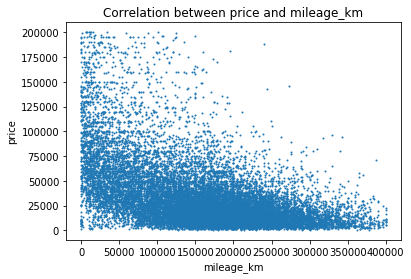

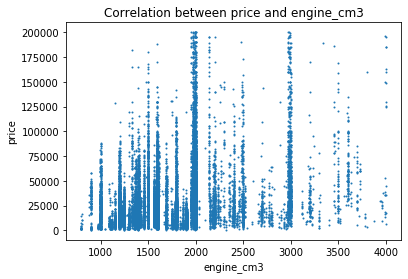

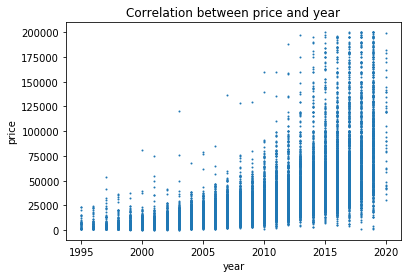

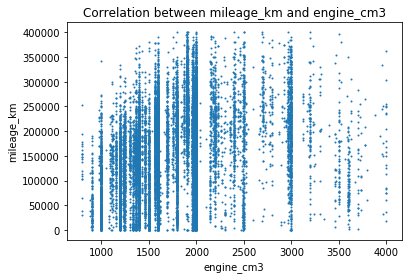

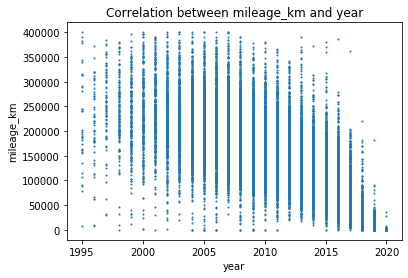

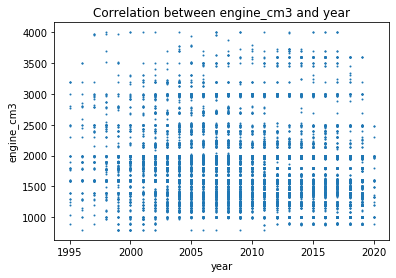

In [20]:
x.scatter()

In [ ]:
for variable in enumerate(['price', 'mileage_km', 'engine_cm3', 'year']):
    print(variable[1])

In [ ]:
x = CarData('data/')

In [ ]:
x.outliers()

In [ ]:
x.missing, x.duplicates

In [ ]:
x.describe()

In [ ]:
x.scatter_nox()

In [ ]:
plt.hist(x.data['mileage_km'], bins = 100)
plt.title('abc')
plt.show()

plt.hist(x.data['price'],bins = 100)
plt.show()

plt.hist(x.data['year'], bins = 100)
plt.show()

plt.hist(x.data['engine_cm3'], bins = 100)
plt.show()

In [ ]:
x.data[x.data['price']>1100000]

In [ ]:
x.data[x.data['mileage_km']>1500000]

In [ ]:
x.data[x.data['year']<1990]

In [ ]:
round(pd.DataFrame(
    data = x.data[['price', 'mileage_km', 'year', 'engine_cm3']].describe(),
    columns = x.data[['price', 'mileage_km', 'year', 'engine_cm3']].columns),2)

In [ ]:
x.data.isnull().sum()

In [ ]:
data = pd.read_csv('run_results_21-04-2020.csv')

In [ ]:
data = ReadAndPreprocess(df)

In [ ]:
df = pd.read_csv('data/run_results_21-04-2020.csv')
df.head()

In [ ]:
df2 = pd.read_csv('data/run_results_25-04_2020.csv')
df2.head()

In [ ]:
df3 = pd.read_csv('data/run_results_26-04-2020.csv')
df3.head()

In [ ]:
x.df_head()